In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import factorial
from jitcsde import jitcsde, y, t

In [2]:
# creating the ensemble

dt = 0.01
g = 0.2

n_s = 10 ** 4      # time for time-series become stationary
n = 10 ** 6        # number of data points in final time-series

N = n + n_s

time = np.arange(0, N) * dt

df = []

n_ensemble = 10
for i in range(n_ensemble):
    
    t_series = np.zeros((N, 2))

    drift = [4 * y(0) - y(0) ** 3,
            -y(0) * y(1)]
    
    diffusion = [g, g]
    
    I = jitcsde(drift, diffusion)

    I.set_integration_parameters(atol=1e-8, first_step=0.001, max_step=0.01, min_step=1e-13)
    
    # Dynamical analysis shows that a negative initial value for x1 results in x2 divergence
    I.set_initial_value([10.0, 0.0], 0)
    
    for j, t_j in enumerate(time):
        t_series[j] = I.integrate(t_j)
        
    t_series = pd.DataFrame(t_series[n_s:], columns=['$x_1$', '$x_2$'])
    t_series['$t$'] = time[n_s:] - time[n_s]
    t_series['dx1'] = -t_series['$x_1$'].diff(periods=-1)
    t_series['dx2'] = -t_series['$x_2$'].diff(periods=-1)
    t_series['(dx1)^2'] = t_series['dx1'] ** 2
    t_series['(dx2)^2'] = t_series['dx2'] ** 2
    t_series['(dx1)(dx2)'] = t_series['dx1'] * t_series['dx2']
    t_series['ensemble'] = i
    
    df.append(t_series)
    
df = pd.concat(df, ignore_index=True)

Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.
Generating, compiling, and loading C code.


In [3]:
#binning data , 11 bins from mean-2*sigma to mean+2*sigma

n_bins = 11

mean1 = round(df['$x_1$'].mean(), 2)
sigma1 = round(df['$x_1$'].std(), 2)

mean2 = round(df['$x_2$'].mean(), 2)
sigma2 = round(df['$x_2$'].std(), 2)

binedges1 = np.linspace(mean1-2*sigma1, mean1+2*sigma1, num=n_bins+1)
binedges2 = np.linspace(mean2-2*sigma2, mean2+2*sigma2, num=n_bins+1)

df['bin1'] = pd.cut(df['$x_1$'], bins=binedges1, 
                    labels=np.arange(n_bins), include_lowest=True, retbins=False)

df['bin2'] = pd.cut(df['$x_2$'], bins=binedges2,
                    labels=np.arange(n_bins), include_lowest=True, retbins=False)

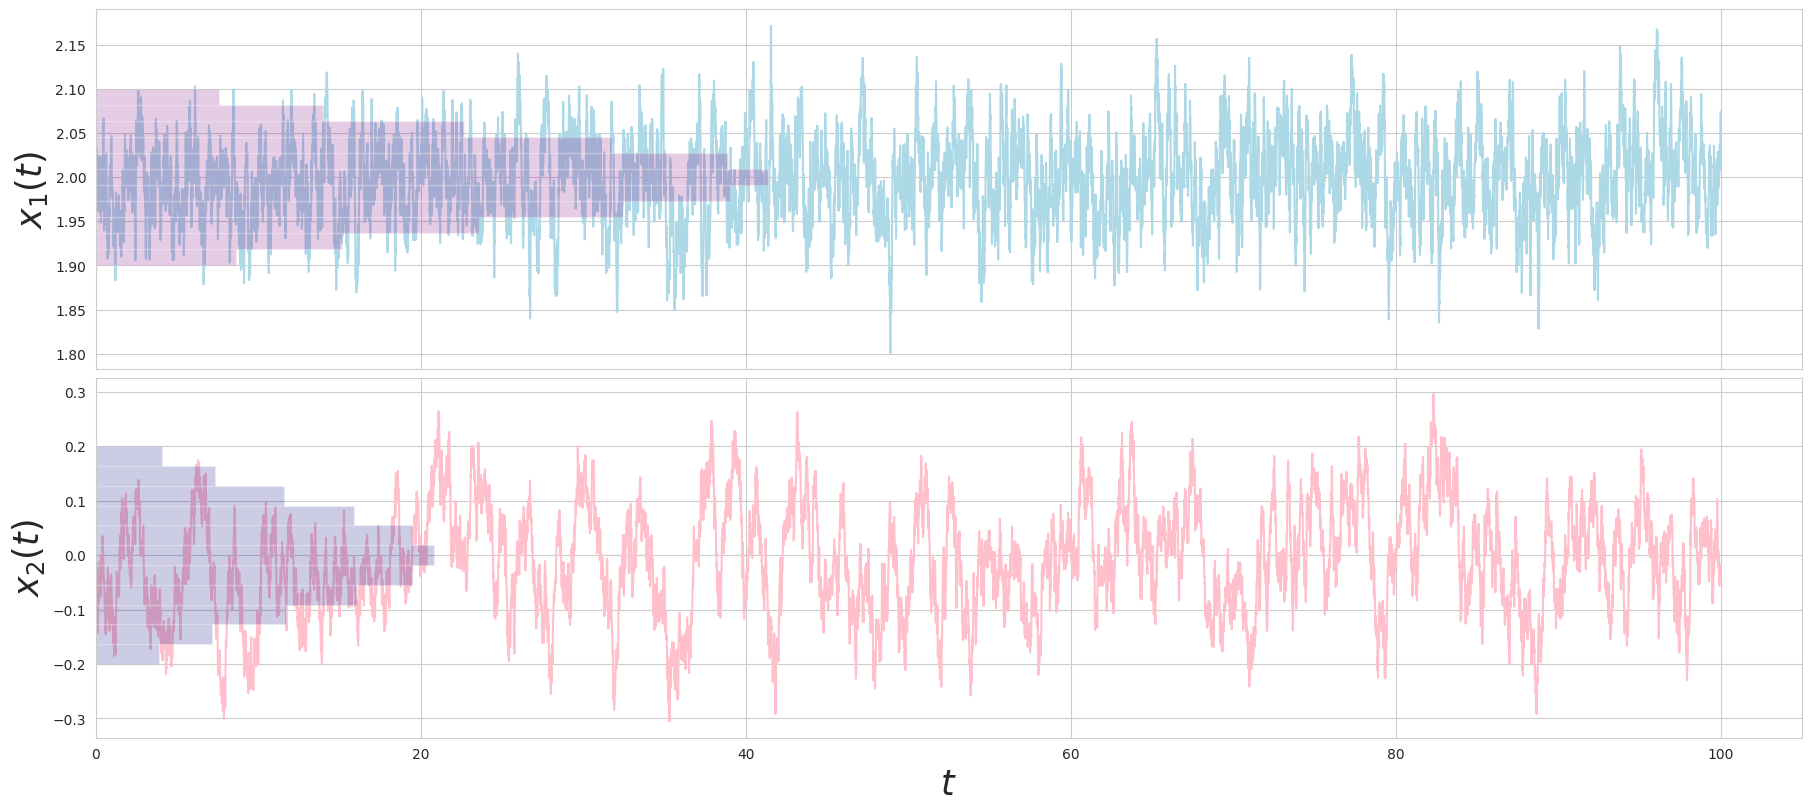

In [4]:
# plot one set of time-series and their distributions

df_ts1 = df[df['ensemble'] == 0]

sns.set_style('whitegrid')

fig1, axs1 = plt.subplots(2, 1, figsize=(18, 8), layout='constrained', sharex=True)

axs1[0].plot(df_ts1['$t$'][:10**4], df_ts1['$x_1$'][:10**4], color='lightblue', zorder=1)
hist1 = np.histogram(df_ts1['$x_1$'], bins=binedges1, density=True)
axs1[0].hist(hist1[1][:-1], bins=hist1[1], orientation='horizontal', weights=hist1[0]*5,
             color='purple', alpha=0.2, zorder=2)
axs1[0].set_ylabel('$x_1(t)$', fontsize=25)

axs1[1].plot(df_ts1['$t$'][:10**4], df_ts1['$x_2$'][:10**4], color='pink', zorder=1)
hist2 = np.histogram(df_ts1['$x_2$'], bins=binedges2, density=True)
axs1[1].hist(hist2[1][:-1], bins=hist2[1], orientation='horizontal', weights=hist2[0]*5,
             color='navy', alpha=0.2, zorder=2)
axs1[1].set_ylabel('$x_2(t)$', fontsize=25)
axs1[1].set_xlabel('$t$', fontsize=25)


plt.show()

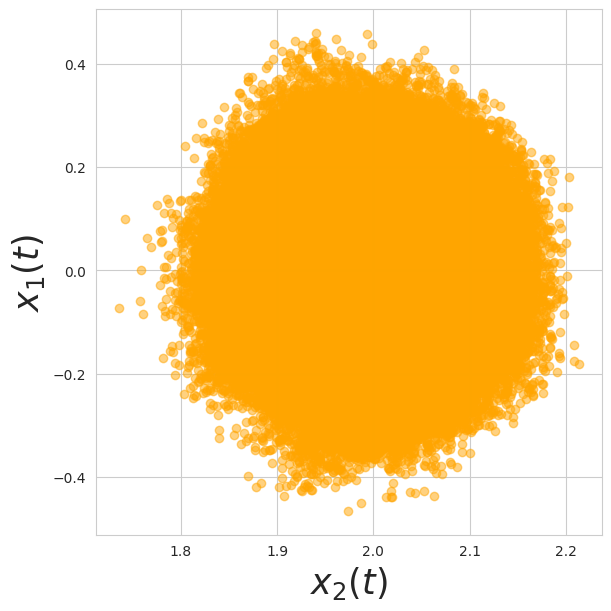

In [5]:
# check correlation between x1 and x2 for one set of time-series

fig2, ax2 = plt.subplots(figsize=(6, 6), layout='constrained')

ax2.scatter(df_ts1['$x_1$'], df_ts1['$x_2$'], c='orange', alpha=0.5)

ax2.set_ylabel('$x_1(t)$',fontsize='25')
ax2.set_xlabel('$x_2(t)$',fontsize='25')

plt.show()

In [6]:
# calculating center of bins

x1_bins = (binedges1[1:] + binedges1[:-1]) / 2
x2_bins = (binedges2[1:] + binedges2[:-1]) / 2

# Drift

In [7]:
# calculating theoretical values of drifts (4x1 - x1^3) and (-x1 x2)

x1g, x2g = np.meshgrid(x1_bins, x2_bins)

D1_1t = 4 * x1g - x1g ** 3
D1_2t = -x1g * x2g

In [8]:
# calculating drifts from time-series

tt = (1 / dt)
drift = pd.DataFrame()

gp = df.groupby(['ensemble', 'bin2', 'bin1'])

drift['D1_1'] = tt * gp['dx1'].mean()
drift['D1_2'] = tt * gp['dx2'].mean()

drift.reset_index(inplace=True)

gp_drift = drift.groupby(['bin1', 'bin2'])

D1_1 = gp_drift['D1_1'].mean().values.reshape(n_bins, n_bins)
err_D_1_1 = (gp_drift['D1_1'].std() / np.sqrt(n_ensemble)).values.reshape(n_bins, n_bins)

D1_2 = gp_drift['D1_2'].mean().values.reshape(n_bins, n_bins)
err_D_1_2 = (gp_drift['D1_2'].std() / np.sqrt(n_ensemble)).values.reshape(n_bins, n_bins)

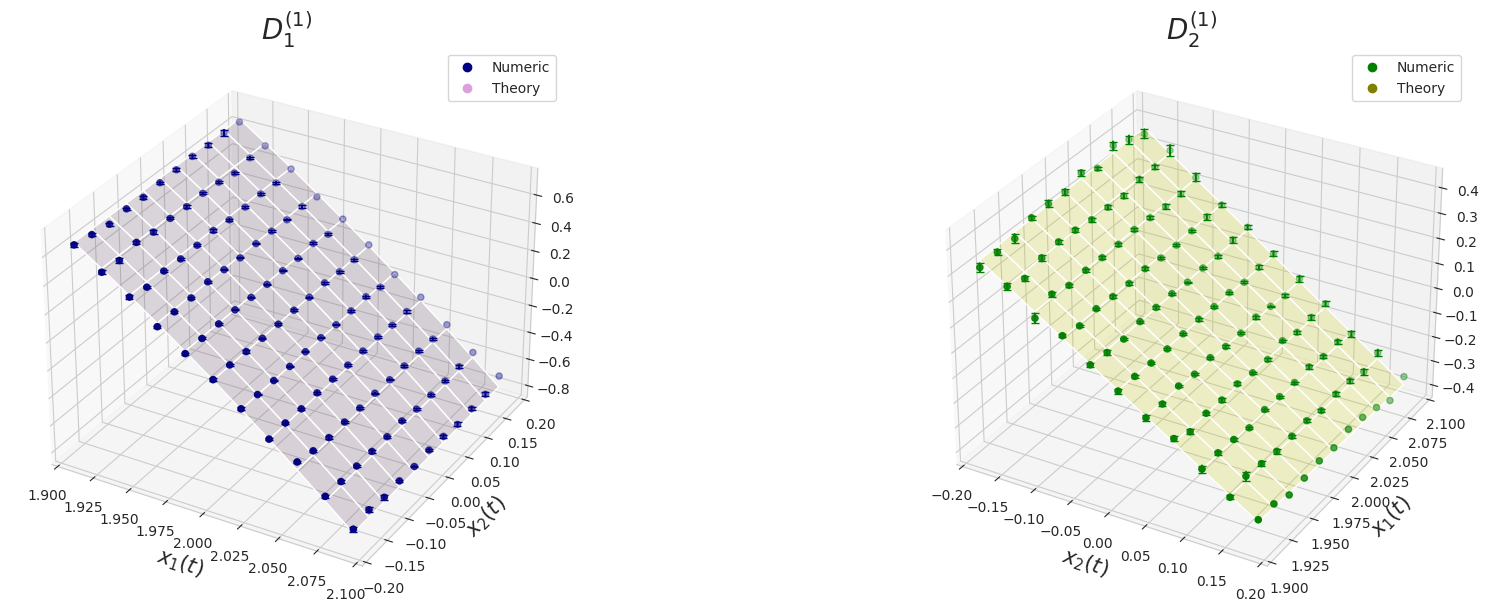

In [9]:
#plot drifts

fig3, axs3 = plt.subplots(1, 2, figsize=(18, 6), layout='constrained', subplot_kw=dict(projection='3d'))

axs3[0].scatter(x1g, x2g, D1_1.T, color='navy')
axs3[0].plot_surface(x1g, x2g, D1_1t, color='plum', alpha=0.2)
axs3[0].set_title("$D^{(1)}_1$", fontsize=20)
axs3[0].set_xlabel('$x_1(t)$', fontsize=15)
axs3[0].set_ylabel('$x_2(t)$', fontsize=15)

# plot error bars
for i in np.arange(0, len(x1g)-1):  # Lines were modified here!
    for xval, yval, zval, zerr in zip(x1g[i], x2g[i], D1_1.T[i], err_D_1_1.T[i]):
        axs3[0].plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='navy')

fake2Dline1n = mpl.lines.Line2D([0],[0], linestyle="none", c='navy', marker='o')
fake2Dline1t = mpl.lines.Line2D([0],[0], linestyle="none", c='plum', marker='o')
axs3[0].legend([fake2Dline1n, fake2Dline1t], ['Numeric', 'Theory'], loc='best', numpoints=1)


axs3[1].scatter(x2g, x1g, D1_2.T, color='green')
axs3[1].plot_surface(x2g, x1g, D1_2t, color='yellow', alpha=0.2)
axs3[1].set_title("$D^{(1)}_2$", fontsize=20)
axs3[1].set_xlabel('$x_2(t)$', fontsize=15)
axs3[1].set_ylabel('$x_1(t)$', fontsize=15)

#plot error bars
for i in np.arange(0, len(x1g)-1):  # Lines were modified here!
    for xval, yval, zval, zerr in zip(x2g[i], x1g[i], D1_2.T[i], err_D_1_2.T[i]):
        axs3[1].plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='green')

fake2Dline2n = mpl.lines.Line2D([0],[0], linestyle="none", c='green', marker='o')
fake2Dline2t = mpl.lines.Line2D([0],[0], linestyle="none", c='olive', marker='o')
axs3[1].legend([fake2Dline2n, fake2Dline2t], ['Numeric', 'Theory'], loc='best', numpoints=1)

plt.show()

# Diffusion

In [10]:
#theoretical values of diffusions (g ** 2 & 0)

g = 0.2

D2_11t = np.ones((11, 11)) * (g ** 2)
D2_12t = np.zeros((11, 11))
D2_22t = np.ones((11, 11)) * (g ** 2)

In [11]:
# caculating diffusion

diffusion = pd.DataFrame()

gp_ens = df.groupby(['ensemble', 'bin2', 'bin1'])

diffusion['D2_11'] = tt * gp_ens['(dx1)^2'].mean()
diffusion['D2_12'] = tt * gp_ens['(dx1)(dx2)'].mean()
diffusion['D2_22'] = tt * gp_ens['(dx2)^2'].mean()

diffusion.reset_index(inplace=True)

gp_diffusion = diffusion.groupby(['bin1', 'bin2'])

D2_11 = np.round(gp_diffusion['D2_11'].mean().values, 2).reshape(n_bins, n_bins)
err_D2_11 = (gp_diffusion['D2_11'].std() / np.sqrt(n_ensemble)).values.reshape(n_bins, n_bins)

D2_12 = np.round(gp_diffusion['D2_12'].mean().values, 2).reshape(n_bins, n_bins)
err_D2_12 = (gp_diffusion['D2_12'].std() / np.sqrt(n_ensemble)).values.reshape(n_bins, n_bins)

D2_22 = np.round(gp_diffusion['D2_22'].mean().values, 2).reshape(n_bins, n_bins)
err_D2_22 = (gp_diffusion['D2_22'].std() / np.sqrt(n_ensemble)).values.reshape(n_bins, n_bins)

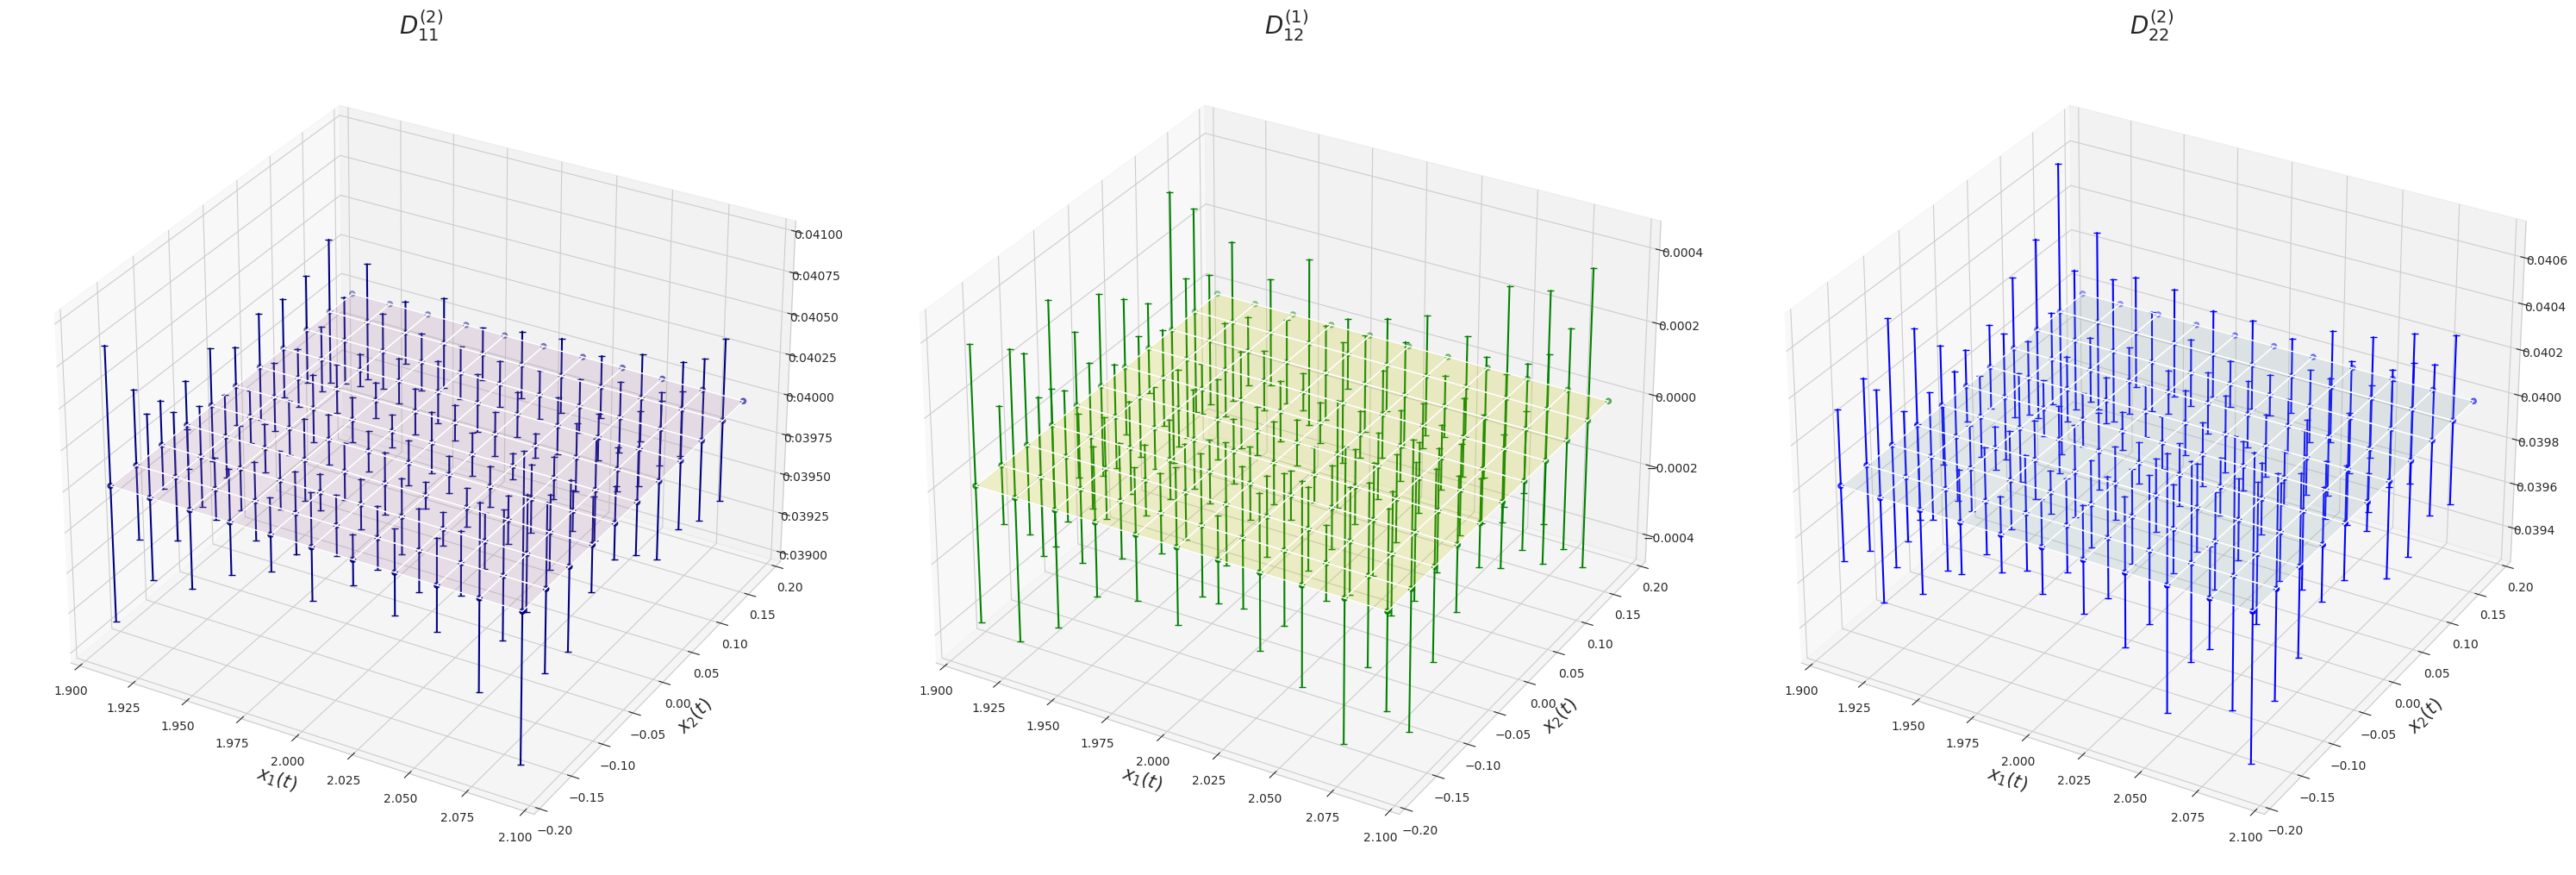

In [12]:
#plot diffusion

fig4, axs4 = plt.subplots(1, 3, figsize=(30, 10), layout='constrained', subplot_kw=dict(projection='3d'))

axs4[0].scatter(x1g, x2g, D2_11.T, color='navy')
axs4[0].plot_surface(x1g, x2g, D2_11t, color='plum', alpha=0.2)
axs4[0].set_title("$D^{(2)}_{11}$", fontsize=20)
axs4[0].set_xlabel('$x_1(t)$', fontsize=15)
axs4[0].set_ylabel('$x_2(t)$', fontsize=15)

# plot error bars
for i in np.arange(0, len(x1g)-1):  # Lines were modified here!
    for xval, yval, zval, zerr in zip(x1g[i], x2g[i], D2_11.T[i], err_D2_11.T[i]):
        axs4[0].plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='navy')


axs4[1].scatter(x1g, x2g, D2_12.T, color='green')
axs4[1].plot_surface(x1g, x2g, D2_12t, color='yellow', alpha=0.2)
axs4[1].set_title("$D^{(1)}_{12}$", fontsize=20)
axs4[1].set_xlabel('$x_1(t)$', fontsize=15)
axs4[1].set_ylabel('$x_2(t)$', fontsize=15)

# plot error bars
for i in np.arange(0, len(x1g)-1):  # Lines were modified here!
    for xval, yval, zval, zerr in zip(x1g[i], x2g[i], D2_12.T[i], err_D2_12.T[i]):
        axs4[1].plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='green')

axs4[2].scatter(x1g, x2g, D2_22.T, color='blue')
axs4[2].plot_surface(x1g, x2g, D2_22t, color='lightblue', alpha=0.2)
axs4[2].set_title("$D^{(2)}_{22}$", fontsize=20)
axs4[2].set_xlabel('$x_1(t)$', fontsize=15)
axs4[2].set_ylabel('$x_2(t)$', fontsize=15)

# plot error bars
for i in np.arange(0, len(x1g)-1):  # Lines were modified here!
    for xval, yval, zval, zerr in zip(x1g[i], x2g[i], D2_22.T[i], err_D2_22.T[i]):
        axs4[2].plot([xval, xval], [yval, yval], [zval+zerr, zval-zerr], marker="_", color='blue')

plt.show()